## How to use Nik's DXF/NPGS code

In [1]:
# matplotlib imports are only needed if you plan on plotting stuff
%matplotlib notebook
import matplotlib.pyplot as plt

# autoreload is here for troubleshooting
%load_ext autoreload
% autoreload 2

# this is the only important import
import dxfasc

### Checking out what is in a file

We will look at one of my GaAs 2DEG samples as an example. I made this drawing in AutoCAD and exported it as a DXF. We can start by looking at what layers this drawing contains. To make things a little simpler to keep track of, layernames are changed to be in all caps with spaces replaced by underscores.

In [2]:
dxfasc.print_layer_names('gaas_example_drawing.dxf')

0:  0
1:  WRITE_FIELDS
2:  OHMIC_CONTACTS
3:  OHMIC_PADS
4:  ROTATION_ALIGN
5:  ETCH
6:  ETCH_ALIGN


Cool. Now we can plot a layer from the drawing. Since the `OHMIC_CONTACTS` layer was written first, let's take a look at that.

<IPython.core.display.Javascript object>


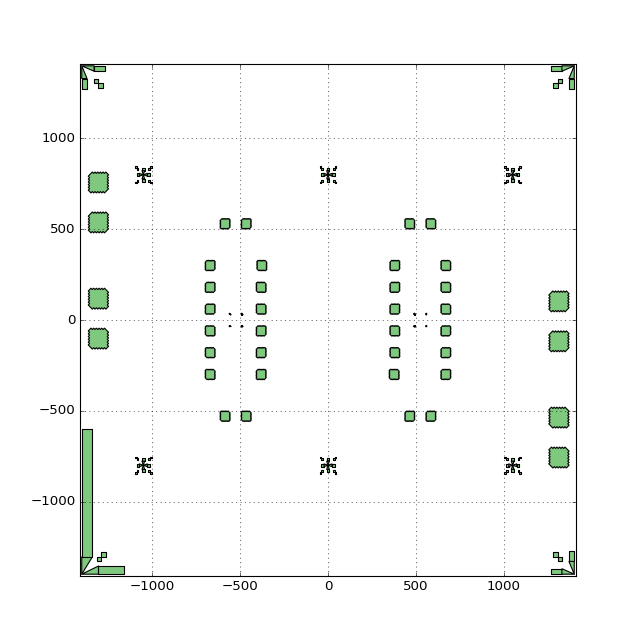

In [4]:
fig, ax = plt.subplots(1,1, figsize = (8,8))
f = 'gaas_example_drawing.dxf'
layers = ['OHMIC_CONTACTS']
d = dxfasc.Layers(f, layers)
d.plot(ax)

To make the plotting a little easier to navigate, the center of the selected layers is moved to the origin of the plot. It is possible to find the center of the write field in the original coordinates, which can be useful for stage movements.

In [5]:
d.find_writefield_center()

center of writefield: 1400.0,1400.0


In [6]:
dose = 165 #uC/cm^2
current = 320 # pA
d.estimate_writetime(dose, current)

Time to write OHMIC_CONTACTS: 23.4 min


## Convert drawing to DC2

The main motivation for this software was to avoid opening and edit the DXF files in DesignCAD in order to produce a usable DC2 file. The script makes a number of changes to the drawing in order to produce the most useful DC2 otuput.

0. any lines with width are converted to polygons
1. all polygons are closed properly
2. any duplicate polygons are removed (in case something is hiding in your drawing)
3. polygons vertices are ordered counter-clockwise
4. polygon vertices are ordered such that polygons are written with the beam moving parallel to the longest side
6. the write order is arranged by center of mass of polygons starting in the lower left corner of the drawing, ordering from left to right, top to bottom.

The `origin` keyword will change your coordinate system so that the origin is in the center of the pattern (`origin = 'center'`), at the lower left corner of the pattern (`origin = 'lower'`), or unchanged from your DXF (`origin = None`).

**KNOWN PROBLEMS**: The script will fail if you use lines of variable width in your DXF drawing. This is pretty uncommon, though. This code also does not support the creation of NPGS run files. Those rely heavily on calibration files that I do not have access to. 

**UNKNOWN PROBLEMS**: I assume there are a lot. This code has not been extensively tested.

### Processing a single layer

This will create a DC2 file with a single layer (single color).

In [7]:
d.process_files_for_npgs(origin='center')

pattern output: gaas_example_drawing_OHMIC_CONTACTS.dc2


Here is a screenshot of the pattern output `gaas_example_drawing_OHMIC_CONTACTS.dc2` <img src="files/ohmic_contacts_dc2.png">


### Processing multiple layers

This will create a DC2 file with multiple layers (multiple colors).

In [8]:
f = 'gaas_example_drawing.dxf'
layers = ['OHMIC_CONTACTS', 'ETCH']
d = dxfasc.Layers(f, layers)

d.process_files_for_npgs(origin='center')

pattern output: gaas_example_drawing_OHMIC_CONTACTS-ETCH.dc2


Here is a screenshot of the pattern output `gaas_example_drawing_OHMIC_CONTACTS-ETCH.dc2` <img src="files/ohmic_contacts-etch_dc2.png">

### Processing a single layer with alignment

Any layer that contains the string 'align' in the layername will be treated independently of the other layers passed to `process_files_for_npgs`. To take advantage of these features your alignment layer should contain simple boxes centered on your alignment markers. I will plot this example before processing the DC2 files. 

<IPython.core.display.Javascript object>


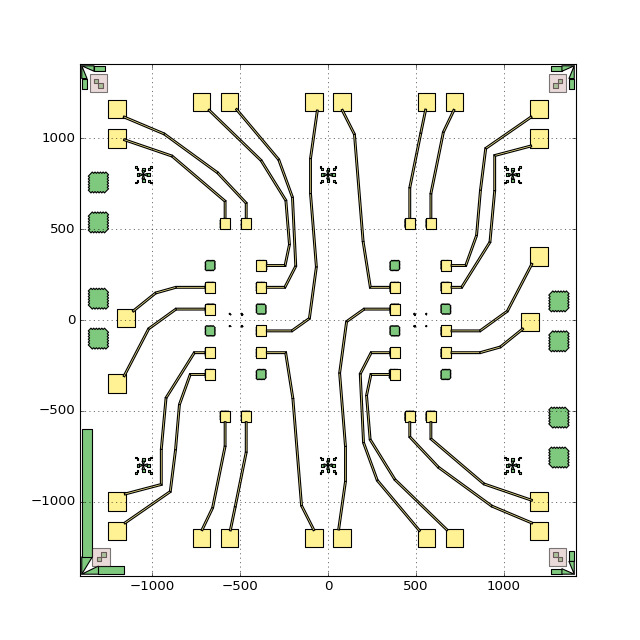

In [9]:
f = 'gaas_example_drawing.dxf'
layers = ['OHMIC_CONTACTS', 'OHMIC_PADS', 'ROTATION_ALIGN']
d = dxfasc.Layers(f, layers)

fig, ax = plt.subplots(1,1, figsize = (8,8))
d.plot(ax)

Here we see the original 'OHMIC_CONTACTS' layer in green. We want to write the yellow 'OHMIC_PADS' layer next, and we will use the semi-transparent purple 'ROTATION_ALIGN' layer to do manual alignment of the layers.

In [12]:
f = 'gaas_example_drawing.dxf'
layers = ['OHMIC_PADS', 'ROTATION_ALIGN']
d = dxfasc.Layers(f, layers)

d.process_files_for_npgs(origin='center')

alignment output: gaas_example_drawing_ROTATION_ALIGN.dc2, gaas_example_drawing_ROTATION_ALIGN.txt
pattern output: gaas_example_drawing_OHMIC_PADS.dc2


There are three files produced by this function. The pattern output `gaas_example_drawing_OHMIC_PADS.dc2` is simply a DC2 file with one layer containing the layer I want to write.

The alignment output consists of two files. The most important is `gaas_example_drawing_ROTATION_ALIGN.dc2`. This DC2 file contains 4 layers, one for each alignment scan, as required by NPGS. Each layer contains the box defining an alignment scan area as well as a cross (automatically generated) that will be used in NPGS to position the alignment markers within the scan. Here is a screenshot of the `gaas_example_drawing_ROTATION_ALIGN.dc2` in DesignCAD:

<img src="files/rotation_align_dc2.png">

Notice there are four layers 'MARKER0'-'MARKER3'. Each of these contains one alignment marker scan box and one automatically-generated cross.

The other alignment output file is `gaas_example_drawing_ROTATION_ALIGN.txt`. This is a plain text document giving some information about the alignment markers. It looks like this:

    MARKER LOCATIONS: 
    [[-1290. -1305.]
     [ 1305. -1305.]
     [-1305.  1305.]
     [ 1305.  1305.]]
    VECTOR FROM MARKER 0: 
    [[    0.     0.]
     [ 2595.     0.]
     [  -15.  2610.]
     [ 2595.  2610.]]
     
The markers are ordered starting in the bottom left corner from left to right, top to bottom. This file is useful for navigation and global rotation corrections.